In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.applications import EfficientNetB0

import os
import math
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

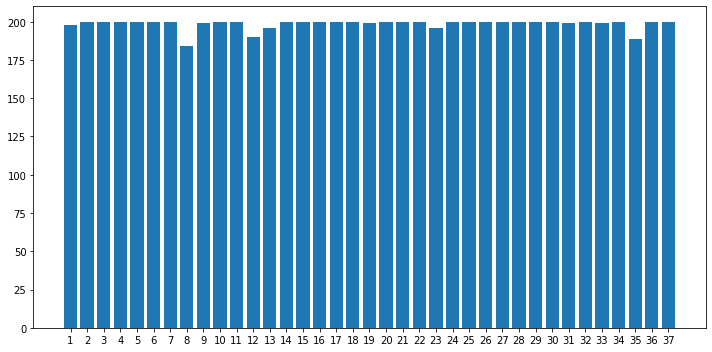

In [2]:
#Image CLASS-ID SPECIES BREED ID
#ID: 1:37 Class ids
#SPECIES: 1:Cat 2:Dog
#BREED ID: 1-25:Cat 1:12:Dog
#All images with 1st letter as captial are cat images
#images with small first letter are dog images
csv_path = 'data/kfolds.csv'
df = pd.read_csv(csv_path)
np.unique(df['id'])

value_counts = df['id'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
plt.bar(range(len(value_counts)), value_counts.values)
plt.xticks(range(len(value_counts)), value_counts.index.values)
plt.tight_layout()
plt.show()


* binary_crossentropy : binary 다중 분류 손실함수, label들이 독립적일 때 사용
* categorical_crossentropy : 다중 분류 손실함수, 출력값이 one-hot encoding된 결과로 나옴, 각 샘플이 정확히 하나의 클래스에 속하는 경우 사용
* sparse_categorical_crossentropy : 다중 분류 손실함수, one-hot encoding을 하지 않고 정수 형태로 넣어줌, 한 샘플에 여러 클래스가 있거나 label이 soft 확률일 경우 사용

In [3]:
def get_model(input_shape):
    inputs = keras.Input(input_shape)
    base_model = EfficientNetB0(
        input_shape = input_shape,
        weights = 'imagenet',
        include_top = False,
        pooling='avg'
    )
    
    x= base_model(inputs)
    output = layers.Dense(1, activation='softmax')(x)
    model = keras.Model(inputs, output)
    
    return model

input_shape = (256, 256, 3)
model =get_model(input_shape)

adam = keras.optimizers.Adam(lr=0.0001)

model.compile(
    optimizer=adam,
    loss='sparse_categorical_crossentropy',
    metrics='accuracy'
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 4,008,829
Non-trainable params: 42,023
_________________________________________________________________


f:\python\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


* softmax
- 출력은 0 ~ 1 사이의 실수
- 출력을 확률로 해석할 수 있음
- 출력의 총합은 1임

In [4]:
import albumentations as A

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            self.transform = A.Compose([
                # 수평
                A.HorizontalFlip(p=0.5),
                # 이동, 크기, 회전을 설정
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                ),
                # 최대 8개의 구멍을 dropout 하게됨
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2)
            ])
            
    def __call__(self, **kwargs):
        if self.transform:
            augmented =self.transform(**kwargs)
            img = augmented['image']
            return img

In [5]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.fold = fold
        self.image_size = image_size
        self.mode = mode
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        #### https://github.com/tensorflow/models/issues/3134
        #### 파일 이슈 -> 삭제
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['file_name'].isin(invalid_filenames)]
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()

        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
            return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        batch_x, batch_y = self.get_data(data)
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            image = cv2.imread(f'data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            if self.mode == 'train':
                image = image.astype('uint8')
                image = self.transform(image=image)
            
            image = image.astype('float32')            
            image = image / 255.
        
            label = int(r['id']) - 1
            
            batch_x.append(image)
            batch_y.append(label)
        return batch_x, batch_y

In [6]:
csv_path = 'data/kfolds.csv'

train_generator = DataGenerator(
    batch_size = 128,
    csv_path = csv_path,
    fold = 1,
    image_size = 256,
    mode = 'train',
    shuffle = True
)

valid_generator = DataGenerator(
    batch_size = 128,
    csv_path = csv_path,
    fold = 1,
    image_size = 256,
    mode = 'val',
    shuffle = True
)

In [7]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    verbose=1
)

Epoch 1/10


ResourceExhaustedError: Graph execution error:

Detected at node 'model/efficientnetb0/block4b_dwconv/depthwise' defined at (most recent call last):
    File "f:\python\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "f:\python\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "f:\python\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "f:\python\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "f:\python\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "f:\python\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "f:\python\lib\asyncio\base_events.py", line 541, in run_forever
      self._run_once()
    File "f:\python\lib\asyncio\base_events.py", line 1786, in _run_once
      handle._run()
    File "f:\python\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "f:\python\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "f:\python\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "f:\python\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "f:\python\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "f:\python\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "f:\python\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "f:\python\lib\site-packages\IPython\core\interactiveshell.py", line 2958, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "f:\python\lib\site-packages\IPython\core\interactiveshell.py", line 3003, in _run_cell
      return runner(coro)
    File "f:\python\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "f:\python\lib\site-packages\IPython\core\interactiveshell.py", line 3229, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "f:\python\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "f:\python\lib\site-packages\IPython\core\interactiveshell.py", line 3524, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\jhjun\AppData\Local\Temp\ipykernel_8572\1483182427.py", line 5, in <module>
      verbose=1
    File "f:\python\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "f:\python\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "f:\python\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "f:\python\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "f:\python\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "f:\python\lib\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "f:\python\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "f:\python\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "f:\python\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "f:\python\lib\site-packages\keras\engine\functional.py", line 452, in call
      inputs, training=training, mask=mask)
    File "f:\python\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "f:\python\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "f:\python\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "f:\python\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "f:\python\lib\site-packages\keras\engine\functional.py", line 452, in call
      inputs, training=training, mask=mask)
    File "f:\python\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "f:\python\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "f:\python\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "f:\python\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "f:\python\lib\site-packages\keras\layers\convolutional.py", line 2772, in call
      data_format=self.data_format)
    File "f:\python\lib\site-packages\keras\backend.py", line 5907, in depthwise_conv2d
      data_format=tf_data_format)
Node: 'model/efficientnetb0/block4b_dwconv/depthwise'
OOM when allocating tensor with shape[128,16,16,480] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node model/efficientnetb0/block4b_dwconv/depthwise}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_19431]

In [8]:
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy")
plt.show()

NameError: name 'history' is not defined